# **Log Analysis For AI.**
以下の手順をもとにログ解析AIを実装する。
* `feature extraction` : TF-ILF
* `annotation` : cosine similarity(一部ラベル付けした異常ログからcosine similarityでラベルを生成)
* `Learning` : supervised Learning

# Import

In [1]:
# import
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import  GridSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(os.path.dirname("__file__"), "./src/"))
import load_log
from data_preprocessing import FeatureExtraction

# Config

In [2]:
class Config:
    log_path = "./data/bgl/BGL_2k.log"
    train_size = 0.8
    output_dir = "./model/"
    th =  0.75 # コサイン類似度の閾値
    n_splits = 5
config = Config

# Create Data
* `anomaly_log` : 各異常カテゴリから1件ずつ抽出したデータ (labelは-1)
* `data_log` : 
   * `train` : 学習用データ(正常(label: 0)/未知の異常(label: 1)が含まれるデータ)
   * `test` : 推論用データ(正常/未知の異常が含まれるデータ)

In [3]:
df = load_log.load_bgl(config)
# 異常データ/正常データの分割
normal_df = df[df["label"] == 0]
anomaly_df = df[df["label"] == 1]
# 各カテゴリから異常を一件抽出
KERNDTLB = anomaly_df[anomaly_df["category"] == "KERNDTLB"].head(1)
anomaly_df = anomaly_df.drop(KERNDTLB.index[0], axis=0)
KERNSTOR = anomaly_df[anomaly_df["category"] == "KERNSTOR"].head(1)
anomaly_df = anomaly_df.drop(KERNSTOR.index[0], axis=0)
APPSEV = anomaly_df[anomaly_df["category"] == "APPSEV"].head(1)
anomaly_df = anomaly_df.drop(APPSEV.index[0], axis=0)
KERNMNTF = anomaly_df[anomaly_df["category"] == "KERNMNTF"].head(1)
anomaly_df = anomaly_df.drop(KERNMNTF.index[0], axis=0)
KERNTERM = anomaly_df[anomaly_df["category"] == "KERNTERM"].head(1)
anomaly_df = anomaly_df.drop(KERNTERM.index[0], axis=0)
KERNREC = anomaly_df[anomaly_df["category"] == "KERNREC"].head(1)
anomaly_df = anomaly_df.drop(KERNREC.index[0], axis=0)
APPRES = anomaly_df[anomaly_df["category"] == "APPRES"].head(1)
anomaly_df = anomaly_df.drop(APPRES.index[0], axis=0)
APPREAD = anomaly_df[anomaly_df["category"] == "APPREAD"].head(1)
anomaly_df = anomaly_df.drop(APPREAD.index[0], axis=0)
APPTO = anomaly_df[anomaly_df["category"] == "APPTO"].head(1)
anomaly_df = anomaly_df.drop(APPTO.index[0], axis=0)
KERNRTSP = anomaly_df[anomaly_df["category"] == "KERNRTSP"].head(1)
anomaly_df = anomaly_df.drop(KERNRTSP.index[0], axis=0)
APPCHILD = anomaly_df[anomaly_df["category"] == "APPCHILD"].head(1)
anomaly_df = anomaly_df.drop(APPCHILD.index[0], axis=0)
APPOUT = anomaly_df[anomaly_df["category"] == "APPOUT"].head(1)
anomaly_df = anomaly_df.drop(APPOUT.index[0], axis=0)
# 各カテゴリの異常データの生成
anomaly_log = pd.concat([KERNDTLB, KERNSTOR,APPSEV, KERNMNTF, KERNTERM, KERNREC, APPRES, APPREAD, APPTO, KERNRTSP, APPCHILD, APPOUT])
anomaly_log["label"] = -1  # ラベルは-1とする。
# 未知のデータを生成
data_log = pd.concat([normal_df, anomaly_df]).sample(frac=1)
# 学習/推論用データの生成
train, test = train_test_split(df, train_size=config.train_size, random_state=1, shuffle=True)

## Display Data

In [4]:
print("known anomalous data")
display(anomaly_log.head())
print("train")
display(train.head())
print("test")
display(test.head())

known anomalous data


,log,log(after),label,category
103,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.3...,RAS KERNEL FATAL data TLB error interrupt,-1,KERNDTLB
165,2005.06.13 R10-M1-N5-C:J15-U11 2005-06-13-17.3...,RAS KERNEL FATAL data storage interrupt,-1,KERNSTOR
1256,2005.08.14 R21-M0-N8-I:J18-U11 2005-08-14-19.0...,RAS APP FATAL ciod Error reading message prefi...,-1,APPSEV
1376,2005.08.31 R42-M1-NC-I:J18-U11 2005-08-31-22.2...,NC NC RAS KERNEL FATAL Lustre mount FAILED poi...,-1,KERNMNTF
1029,2005.07.18 R20-M1-N8-C:J12-U01 2005-07-18-15.5...,RAS KERNEL FATAL rts kernel terminated for rea...,-1,KERNTERM


train


,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
816,2005.07.10 R24-M1-N6-C:J05-U01 2005-07-10-07.4...,RAS KERNEL INFO generating core,0,normal
790,2005.07.09 R35-M0-NE-C:J03-U11 2005-07-09-21.2...,NE NE RAS KERNEL INFO generating core,0,normal
361,2005.06.20 R14-M1-N0-I:J18-U01 2005-06-20-16.2...,RAS APP FATAL ciod Error loading home draeger ...,0,normal
592,2005.07.04 R34-M0-N5-C:J04-U01 2005-07-04-07.3...,RAS KERNEL INFO generating core,0,normal


test


,log,log(after),label,category
674,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.5...,RAS KERNEL INFO generating core,0,normal
1699,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.0...,RAS KERNEL INFO iar dear,0,normal
1282,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.4...,RAS KERNEL INFO iar dear,0,normal
1315,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.2...,RAS KERNEL INFO double hummer alignment except...,0,normal
1210,2005.08.03 NULL 2005-08-03-16.12.54.271533 NUL...,NULL NULL RAS MMCS ERROR idoproxydb hit ASSERT...,0,normal


## Display Category

In [5]:
print("known anomalous data")
anomaly_log_info = anomaly_log.groupby(["label", "category"]).size()
anomaly_log_info = pd.DataFrame(anomaly_log_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
display(anomaly_log_info)
print("train")
train_info = train.groupby(["label", "category"]).size()
train_info = pd.DataFrame(train_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
display(train_info)
print("test")
test_info = test.groupby(["label", "category"]).size()
test_info = pd.DataFrame(test_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
display(test_info)

known anomalous data


count
label category       
-1    APPCHILD      1
      APPOUT        1
      APPREAD       1
      APPRES        1
      APPSEV        1
      APPTO         1
      KERNDTLB      1
      KERNMNTF      1
      KERNREC       1
      KERNRTSP      1
      KERNSTOR      1
      KERNTERM      1

train


count
label category       
1     KERNDTLB     48
      KERNSTOR     23
      APPSEV       13
      KERNMNTF      7
      KERNTERM      6
      KERNREC       4
      APPRES        3
      APPREAD       2
      APPTO         2
      KERNRTSP      2
      APPCHILD      1
      APPOUT        1
0     normal     1488

test


count
label category       
1     KERNDTLB     12
      KERNSTOR      7
      APPSEV        4
      KERNMNTF      4
      APPREAD       1
      APPRES        1
      KERNREC       1
      KERNTERM      1
0     normal      369

# Feature Extraction
* 既知の異常ログ/学習用データからTF-ILFを用いて特徴量抽出を抽出する。
* 推論用データの特徴量抽出を抽出する。

In [6]:
# 既知の異常ログ/学習用データの結合
train = pd.concat([train, anomaly_log])
train_feature, vocabulary = FeatureExtraction(train["log(after)"].values, config, mode="train", fe_type="tfilf")()
test_feature, _ = FeatureExtraction(test["log(after)"].values, config, mode="test", fe_type="tfilf")()
# 特徴量抽出データにラベル付け
train_feature[["log", "category", "label"]] = train[["log", "category", "label"]].values
test_feature[["log", "category", "label"]] = test[["log", "category", "label"]].values
# 既知の異常ログ/学習用データの分割
anomaly_feature = train_feature[train_feature["label"] == -1]
train_feature = train_feature[train_feature["label"] != -1].reset_index()
del train_feature["index"]

## Display Feature Data

In [7]:
print("known anomalous data")
display(anomaly_feature.head())
print("train")
display(train_feature.head())
print("test")
display(test_feature.head())

known anomalous data


,0,1,2,3,4,5,6,7,8,9,...,434,435,436,437,438,439,440,log,category,label
1600,3.578531,3.578531,0.0,0.0,0.0,0.0,1.636895,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.3...,KERNDTLB,-1
1601,3.578531,3.578531,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.06.13 R10-M1-N5-C:J15-U11 2005-06-13-17.3...,KERNSTOR,-1
1602,3.578531,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.08.14 R21-M0-N8-I:J18-U11 2005-08-14-19.0...,APPSEV,-1
1603,3.578531,3.578531,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.08.31 R42-M1-NC-I:J18-U11 2005-08-31-22.2...,KERNMNTF,-1
1604,3.578531,3.578531,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.07.18 R20-M1-N8-C:J12-U01 2005-07-18-15.5...,KERNTERM,-1


train


,0,1,2,3,4,5,6,7,8,9,...,434,435,436,437,438,439,440,log,category,label
0,3.578531,3.578531,3.578531,2.887875,2.887875,3.174726,1.636895,2.483241,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,0
1,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.07.10 R24-M1-N6-C:J05-U01 2005-07-10-07.4...,normal,0
2,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.07.09 R35-M0-NE-C:J03-U11 2005-07-09-21.2...,normal,0
3,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.06.20 R14-M1-N0-I:J18-U01 2005-06-20-16.2...,normal,0
4,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.07.04 R34-M0-N5-C:J04-U01 2005-07-04-07.3...,normal,0


test


,0,1,2,3,4,5,6,7,8,9,...,434,435,436,437,438,439,440,log,category,label
0,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,3.550361,2.637059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.5...,normal,0
1,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.0...,normal,0
2,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.4...,normal,0
3,3.550361,3.550361,3.550361,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.2...,normal,0
4,3.550361,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.08.03 NULL 2005-08-03-16.12.54.271533 NUL...,normal,0


# Create Label
学習用のデータのラベルは-1, 0, 1の3種類あるため、利用するラベルを生成する。  
なお、学習用データの異常ラベル(1)は本来、未知の異常データであるため、既知の異常データからコサイン類似度を用いてラベル付けを行う。

In [8]:
# 全ログと各異常ログの類似度から異常を抽出
all_proba_list = []
for row_feature in train_feature.values:
    proba_dict = {}
    analysis_row = row_feature[:-3]
    for anomaly_row in anomaly_feature.values:
        category = anomaly_row[-2]
        anomaly_row = anomaly_row[:-3]
        anom_proba = np.dot(analysis_row, anomaly_row) / (np.linalg.norm(analysis_row) * np.linalg.norm(anomaly_row))
        proba_dict[category] = anom_proba
    max_kv = list(max(proba_dict.items(), key=lambda x: x[1]))
    if max_kv[1] <= config.th:
        max_kv[0] = "normal"
        max_kv.append(0)
    else:
        max_kv.append(1)
    del max_kv[1]
    all_proba_list.append(max_kv)
all_proba = pd.DataFrame(all_proba_list, columns=["category_pred", "use_label"])
all_proba = all_proba[["category_pred","use_label"]]
train_feature = pd.concat([train_feature, all_proba], axis=1)
anomaly_feature["use_label"] = 1
train_feature = pd.concat([train_feature, anomaly_feature])

## Display Data

In [9]:
display(train_feature)

,0,1,2,3,4,5,6,7,8,9,...,436,437,438,439,440,log,category,label,category_pred,use_label
0,3.578531,3.578531,3.578531,2.887875,2.887875,3.174726,1.636895,2.483241,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,0,normal,0
1,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,2005.07.10 R24-M1-N6-C:J05-U01 2005-07-10-07.4...,normal,0,normal,0
2,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,2005.07.09 R35-M0-NE-C:J03-U11 2005-07-09-21.2...,normal,0,normal,0
3,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,2005.06.20 R14-M1-N0-I:J18-U01 2005-06-20-16.2...,normal,0,normal,0
4,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,2.66523,...,0.0,0.0,0.0,0.0,0.0,2005.07.04 R34-M0-N5-C:J04-U01 2005-07-04-07.3...,normal,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,2005.06.04 R04-M1-N4-I:J18-U11 2005-06-04-00.2...,APPREAD,-1,NaN,1
1608,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,2005.11.21 R14-M0-NC-I:J18-U11 2005-11-21-11.0...,APPTO,-1,NaN,1
1609,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,2005.07.11 R01-M0-N1-C:J09-U11 2005-07-11-14.0...,KERNRTSP,-1,NaN,1
1610,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,2005.06.20 R12-M1-NC-I:J18-U11 2005-06-20-19.0...,APPCHILD,-1,NaN,1


# Supervised Learning(LightGBM)

In [10]:
# モデルのインスタンス生成&学習実行
params = {"max_length": [5,8,10]}
clf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=config.n_splits), scoring="recall_macro")
model = clf.fit(train_feature.iloc[:,:-5].values, train_feature["use_label"].values) # TF-ILFで特徴量抽出したデータでモデル生成

[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length


# Top10 KeyWord

In [11]:
# 特徴量重要度(重要視している単語)
print("--- Top10 KeyWord ---")
keyword = pd.DataFrame({"word": vocabulary.keys(), "importance":model.best_estimator_.feature_importances_})
keyword = keyword.sort_values("importance", ascending=False)
display(keyword.head(10))

--- Top10 KeyWord ---


,word,importance
31,data,157
33,interrupt,119
57,address,105
89,p,105
167,rts,104
12,FATAL,85
9,core,72
6,error,67
4,cache,66
13,ciod,63


# Train Score
本来の異常とのスコアを算出

--- confusion_matrix ---


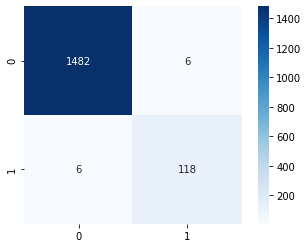

,precision,recall,f1-score,support
0,0.995968,0.995968,0.995968,1488.000000
1,0.951613,0.951613,0.951613,124.000000
accuracy,0.992556,0.992556,0.992556,0.992556
macro avg,0.973790,0.973790,0.973790,1612.000000
weighted avg,0.992556,0.992556,0.992556,1612.000000


In [12]:
### 学習時のスコア表示
# 予測値のデータ生成
y_true = train_feature["label"].apply(lambda x : 1 if x == -1 else x).values
y_pred = model.predict(train_feature.iloc[:,:-5].values)
# スコア算出
cm = confusion_matrix(y_true, y_pred)
classification_result = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
# confusion_matrix
print("--- confusion_matrix ---")
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

# Train Score
コサイン類似度で生成したラベルとのスコアを算出

--- confusion_matrix ---


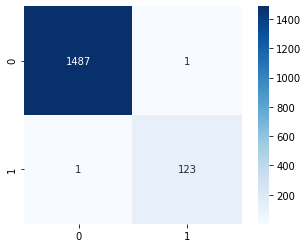

,precision,recall,f1-score,support
0,0.999328,0.999328,0.999328,1488.000000
1,0.991935,0.991935,0.991935,124.000000
accuracy,0.998759,0.998759,0.998759,0.998759
macro avg,0.995632,0.995632,0.995632,1612.000000
weighted avg,0.998759,0.998759,0.998759,1612.000000


In [13]:
### 学習時のスコア表示
# 予測値のデータ生成
y_true = train_feature["use_label"]
y_pred = model.predict(train_feature.iloc[:,:-5].values)
# スコア算出
cm = confusion_matrix(y_true, y_pred)
classification_result = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
# confusion_matrix
print("--- confusion_matrix ---")
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

# Test Score
予測結果を確認

--- confusion_matrix ---


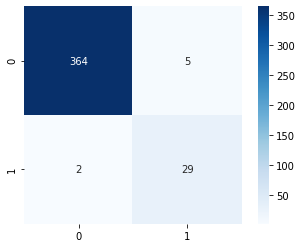

,precision,recall,f1-score,support
0,0.994536,0.986450,0.990476,369.0000
1,0.852941,0.935484,0.892308,31.0000
accuracy,0.982500,0.982500,0.982500,0.9825
macro avg,0.923738,0.960967,0.941392,400.0000
weighted avg,0.983562,0.982500,0.982868,400.0000


In [14]:
### 学習時のスコア表示
# 予測値のデータ生成
y_true = test_feature["label"].values
y_pred = model.predict(test_feature.iloc[:,:-3].values)
y_pred = [int(i) for i in y_pred]
y_true = [int(i) for i in y_true]
# スコア算出
cm = confusion_matrix(y_true, y_pred)
classification_result = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
# confusion_matrix
print("--- confusion_matrix ---")
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

# Check Log
異常のログを確認(異常と判定されたログは赤となる)

In [15]:
# 異常ログの可視化
test_tmp = test_feature[["log", "category", "label"]].copy()
test_tmp["y_pred"] = y_pred
# test_tmp["y_true"] = test_ilf["label"].values
# test_tmp["y_pred"] = y_pred_ilf
# test_tmp = test_tmp[["log", "y_pred", "y_true"]].reset_index()
# del test_tmp["index"]
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
test_tmp.style.apply(highlight_greaterthan, threshold=1.0, column=['y_pred'], axis=1)

,log,category,label,y_pred
0,2005.07.09 R22-M1-N0-C:J05-U11 2005-07-09-11.53.58.430277 R22-M1-N0-C:J05-U11 RAS KERNEL INFO generating core.7167,normal,0,0
1,2005.11.08 R62-M0-N2-C:J13-U11 2005-11-08-10.09.13.667082 R62-M0-N2-C:J13-U11 RAS KERNEL INFO iar 001061e8 dear 0247012c,normal,0,0
2,2005.08.26 R62-M1-N3-C:J04-U01 2005-08-26-11.47.33.903841 R62-M1-N3-C:J04-U01 RAS KERNEL INFO iar 003a90fc dear 00b360e8,normal,0,0
3,2005.08.26 R65-M0-N3-C:J04-U01 2005-08-26-12.26.40.236812 R65-M0-N3-C:J04-U01 RAS KERNEL INFO 1524480 double-hummer alignment exceptions,normal,0,0
4,"2005.08.03 NULL 2005-08-03-16.12.54.271533 NULL RAS MMCS ERROR idoproxydb hit ASSERT condition: ASSERT expression=0 Source file=idotransportmgr.cpp Source line=1043 Function=int IdoTransportMgr::SendPacket(IdoUdpMgr*, BglCtlPavTrace*)",normal,0,0
5,2005.11.04 R62-M0-NC-C:J04-U01 2005-11-04-09.52.27.280593 R62-M0-NC-C:J04-U01 RAS KERNEL INFO iar 0010686c dear 02f6951c,normal,0,0
6,2005.07.07 R12-M1-NE-C:J04-U11 2005-07-07-18.41.19.670878 R12-M1-NE-C:J04-U11 RAS KERNEL INFO generating core.815,normal,0,0
7,2005.06.26 R05-M0-N7-C:J13-U01 2005-06-26-10.28.59.279042 R05-M0-N7-C:J13-U01 RAS KERNEL INFO program interrupt,normal,0,0
8,2005.07.23 R17-M0-N1-C:J06-U11 2005-07-23-17.45.15.142194 R17-M0-N1-C:J06-U11 RAS KERNEL INFO generating core.14250,normal,0,0
9,2005.07.10 R26-M1-N9-C:J02-U01 2005-07-10-07.42.50.396450 R26-M1-N9-C:J02-U01 RAS KERNEL INFO generating core.3851,normal,0,0
